# Python

In [ ]:
# Core data science libraries
import numpy as np
import pandas as pd
import scipy

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Utility libraries
import dill  # For object serialization

# df = pd.read_csv('/home/workspace/pbmc_flow/FH PBMC T Cell data - Counts.csv')
df = pd.read_csv('/home/workspace/pbmc_flow/FH PBMC T Cell data - % CD45+.csv')

In [ ]:
df.head(5)

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Define temporal order for flu study
temporal_order = [
    'Flu Year 1 Day 0', 'Flu Year 1 Day 7', 'Flu Year 1 Day 90',
    'Flu Year 2 Day 0', 'Flu Year 2 Day 7', 'Flu Year 2 Day 90'
]

# Filter to main temporal visits and subjects with complete data
df_temporal = df[df['Visit Type'].isin(temporal_order)].copy()

# Get subjects with data at multiple timepoints
subject_counts = df_temporal['Subject'].value_counts()
complete_subjects = subject_counts[subject_counts >= 4].index[:6]  # Top 6 subjects with most data
df_filtered = df_temporal[df_temporal['Subject'].isin(complete_subjects)]

# Define cell types and colors
cell_types = ['B cells|count', 'T cells|count', 'NK Cells|count', 'Myeloid cells|count']
cell_labels = ['B cells', 'T cells', 'NK cells', 'Myeloid cells']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Calculate percentages for each subject at each timepoint
df_filtered['Total_Immune'] = (df_filtered['B cells|count'] + 
                              df_filtered['T cells|count'] + 
                              df_filtered['NK Cells|count'] + 
                              df_filtered['Myeloid cells|count'])

for cell_type, label in zip(cell_types, cell_labels):
    df_filtered[f'{label}_pct'] = (df_filtered[cell_type] / df_filtered['Total_Immune']) * 100

# Aggregate percentages by timepoint (mean across subjects)
aggregated_data = []
for timepoint in temporal_order:
    timepoint_data = df_filtered[df_filtered['Visit Type'] == timepoint]
    if not timepoint_data.empty:
        agg_row = {'timepoint': timepoint}
        for label in cell_labels:
            agg_row[f'{label}_pct'] = timepoint_data[f'{label}_pct'].mean()
        aggregated_data.append(agg_row)

# Create nodes for Sankey
nodes = []
node_colors = []
node_positions_x = []
node_positions_y = []

# Create nodes for each timepoint
for i, timepoint in enumerate([row['timepoint'] for row in aggregated_data]):
    # Shortened timepoint labels
    short_timepoint = timepoint.replace('Flu Year ', 'Y').replace(' Day ', 'D')
    nodes.append(f"{short_timepoint}")
    node_colors.append('#333333')  # Dark color for timepoint nodes

# Create links between consecutive timepoints
links = {
    'source': [],
    'target': [],
    'value': [],
    'color': [],
    'label': []
}

for i in range(len(aggregated_data) - 1):
    current_data = aggregated_data[i]
    next_data = aggregated_data[i + 1]
    
    for j, (cell_type, color) in enumerate(zip(cell_labels, colors)):
        # Use percentage values for link thickness
        value = (current_data[f'{cell_type}_pct'] + next_data[f'{cell_type}_pct']) / 2
        
        links['source'].append(i)
        links['target'].append(i + 1)
        links['value'].append(value)
        # Convert hex to rgba for transparency
        rgba_color = f"rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.6)"
        links['color'].append(rgba_color)
        links['label'].append(cell_type)

# Create main Sankey diagram
fig = go.Figure()

# Add Sankey diagram
fig.add_trace(go.Sankey(
    node=dict(
        pad=20,
        thickness=30,
        line=dict(color="black", width=0.5),
        label=nodes,
        color=node_colors,
        x=[i/(len(nodes)-1) for i in range(len(nodes))],  # Evenly space nodes horizontally
        y=[0.5] * len(nodes)  # Center nodes vertically
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value'],
        color=links['color']
    )
))

# Add invisible traces for legend
for cell_type, color in zip(cell_labels, colors):
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        name=cell_type,
        showlegend=True
    ))

# Update layout
fig.update_layout(
    title=dict(
        text="Temporal Changes in Immune Cell Composition (%)<br>Flu Vaccine Study Timeline",
        x=0.5,
        font=dict(size=16)
    ),
    font_size=12,
    height=600,
    width=1200,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02,
        title="Cell Types"
    ),
    margin=dict(l=50, r=150, t=80, b=50)
)

# Add annotations for percentage values
annotations = []
for i, data in enumerate(aggregated_data):
    x_pos = i / (len(aggregated_data) - 1) if len(aggregated_data) > 1 else 0.5
    y_start = 0.1
    
    for j, (cell_type, color) in enumerate(zip(cell_labels, colors)):
        pct_value = data[f'{cell_type}_pct']
        annotations.append(dict(
            x=x_pos,
            y=y_start + j * 0.15,
            text=f"{cell_type}: {pct_value:.1f}%",
            showarrow=False,
            font=dict(size=9, color=color),
            xanchor="center"
        ))

fig.update_layout(annotations=annotations)

fig.show()

# Print summary
print(f"Subjects included: {', '.join(complete_subjects)}")
print(f"Timepoints: {len(aggregated_data)}")
print("\nAverage cell type percentages by timepoint:")
for data in aggregated_data:
    print(f"\n{data['timepoint']}:")
    for cell_type in cell_labels:
        print(f"  {cell_type}: {data[f'{cell_type}_pct']:.1f}%")

# R

## Using counts

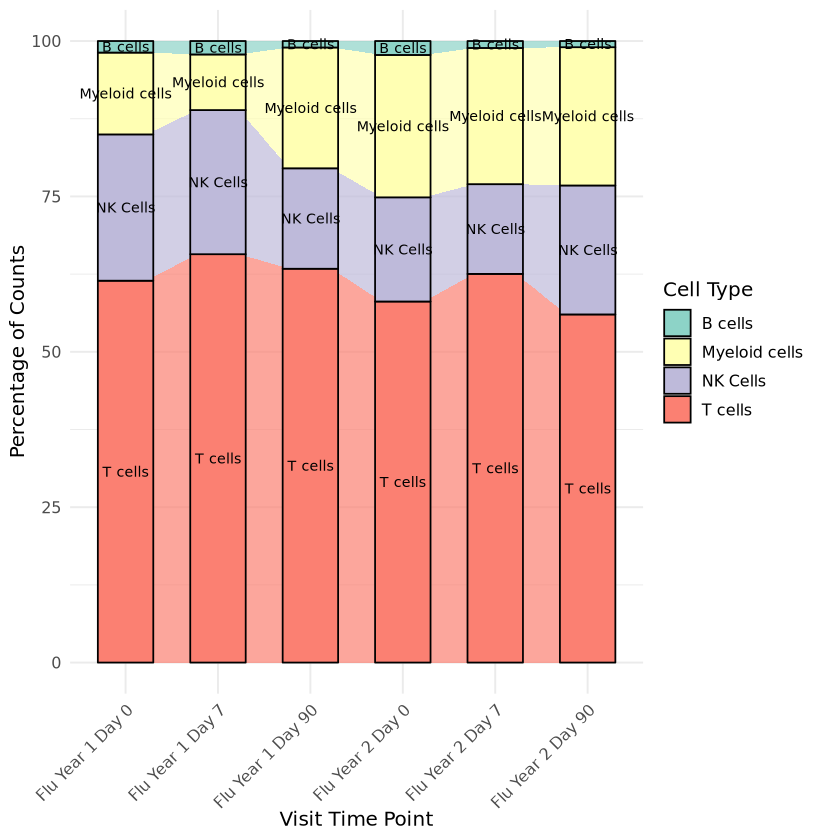

In [10]:
# ============================================================================
# Load required libraries
# ============================================================================
library(ggplot2)      # Core plotting functionality
library(ggalluvial)   # Alluvial plot creation
library(dplyr)        # Data manipulation
library(RColorBrewer) # Color palette generation
library(gridExtra)    # Grid-based plot arrangements
library(rlang)        # Programming tools for R
library(tidyr)        # Data reshaping (pivot functions)

# ============================================================================
# Load data and identify column groups
# ============================================================================
df <- read.csv('/home/workspace/pbmc_flow/FH PBMC T Cell data - Counts.csv')  # Load PBMC flow cytometry data

metadata <- colnames(df)[1:5]          # First 5 columns contain subject info, visit types, etc.
l1_cells <- colnames(df)[c(7:8, 27:28)] # Level 1 cell type count columns
tcells_subsets <- colnames(df)[9:26]   # T cell subset count columns (not used in this analysis)

# ============================================================================
# Filter data for specific subject and timepoints
# ============================================================================
timepoints <- c(                       # Define flu vaccine study timepoints to analyze
    "Flu Year 1 Day 0",
    "Flu Year 1 Day 7",
    "Flu Year 1 Day 90",
    "Flu Year 2 Day 0",
    "Flu Year 2 Day 7",
    "Flu Year 2 Day 90"
)

subjects <- unique(df$Subject)                # Get all unique subject IDs
df <- df[df$Subject == subjects[1],]          # Keep only first subject's data
df <- df[df$Visit.Type %in% timepoints,]      # Keep only specified timepoints
df <- df[, c(metadata, l1_cells)]              # Keep only metadata and cell count columns

# ============================================================================
# Clean column names and identify count columns
# ============================================================================
names(df) <- gsub("\\.", " ", names(df))      # Replace periods with spaces in column names
count_cols <- colnames(df)[6:9]               # Identify columns containing cell counts

# ============================================================================
# Convert absolute counts to percentages
# ============================================================================
row_totals <- rowSums(df[, count_cols])       # Calculate total cells per timepoint
percentages <- df[,]                          # Create copy of dataframe
percentages[, count_cols] <- (df[, count_cols] / row_totals) * 100  # Convert to percentages

# ============================================================================
# Reshape data from wide to long format for ggplot
# ============================================================================
selected_data <- select(percentages, c("Visit Type", count_cols))  # Select columns needed for plot

long_data <- pivot_longer(selected_data,      # Convert to long format
                         cols = all_of(count_cols), 
                         names_to = "cell_type", 
                         values_to = "percentage")

# ============================================================================
# Clean data and set proper factor ordering
# ============================================================================
long_data$cell_type <- gsub(" count", "", long_data$cell_type)                      # Remove " count" from cell type names
long_data$`Visit Type` <- factor(long_data$`Visit Type`, levels = timepoints)       # Order timepoints chronologically
grouped_data <- group_by(long_data, 'Visit Type')                                   # Group by timepoint for plotting

# ============================================================================
# Create color palette based on number of cell types
# ============================================================================
n_cell_types <- length(unique(grouped_data$cell_type))  # Count unique cell types
if (n_cell_types <= 12) {
    colors <- brewer.pal(max(3, n_cell_types), "Set3")  # Use Set3 palette for ≤12 types
} else {
    colors <- c(brewer.pal(12, "Paired"), brewer.pal(8, "Set1"))[1:n_cell_types]  # Combine palettes for >12 types
}

# ============================================================================
# Create and customize alluvial plot
# ============================================================================
p <- ggplot(grouped_data, aes(x = `Visit Type`,   # Initialize plot with alluvial aesthetics
                        stratum = cell_type, 
                        alluvium = cell_type, 
                        y = percentage, 
                        fill = cell_type))

p <- p + geom_alluvium(width = 0.1, alpha = 0.7)  # Add flowing bands between timepoints
p <- p + geom_stratum(width = 0.6)                # Add stacked segments at each timepoint
p <- p + geom_text(stat = "stratum", aes(label = cell_type), size = 3, angle = 0)  # Add cell type labels
p <- p + scale_fill_manual(values = colors)       # Apply custom color palette
p <- p + theme_minimal(base_size = 12)            # Use clean minimal theme
p <- p + theme(                                   # Customize plot appearance
    legend.position = "right", 
    legend.margin = margin(0, 20, 0, 0),
    axis.text.x = element_text(angle = 45, hjust = 1)
)
p <- p + labs(x = "Visit Time Point",                      # Add axis labels
            y = "Percentage of Counts")
p <- p + guides(fill = guide_legend(title = "Cell Type"))  # Set legend title

print(p)  # Display the final plot